# FUCCI RPE1

In [1]:
import os
from tqdm import tqdm
import numpy as np
import scanpy as sc
import scvelo as scv

import sys
sys.path.append("..")
from tivelo.main import tivelo
from baseline import run_baseline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

(Running UniTVelo 0.2.5.2)
2025-04-05 05:05:17


2025-04-05 13:05:17.509500: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Basic settings.

In [2]:
data_name = "rpe1"
data_path = "/lustre/project/Stat/s1155184322/datasets/velocity/FUCCI/adata_fucci_rpe1_processed.h5ad"
save_folder = "results"

result_path = save_folder + "/{}/".format(data_name)
figs_path = save_folder + "/{}/figs/".format(data_name)
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

Load the FUCCI REP1 datasets and plot cell cycle score.

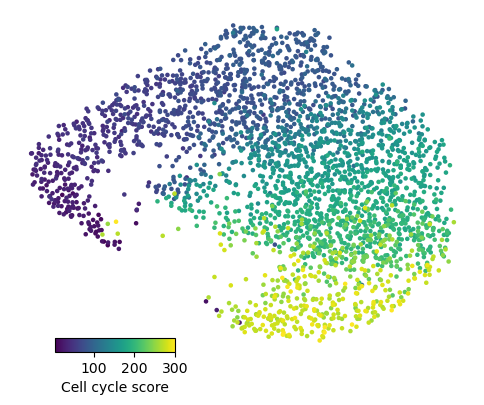

In [3]:
adata = sc.read_h5ad(data_path)
group_key = "leiden"
emb_key = "X_umap"

fig, ax = plt.subplots(figsize=(6, 4.5))
ax = scv.pl.scatter(adata, basis='umap', color='cell_cycle_position', cmap='viridis', title='', ax=ax, show=False, colorbar=False)

# Create a new axes for the colorbar
cax = fig.add_axes([0.2, 0.12, 0.2, 0.03])

# Create a colorbar in the new axes
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=adata.obs['cell_cycle_position'].min(), vmax=adata.obs['cell_cycle_position'].max())
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')

# Add label to the colorbar
cbar.set_label('Cell cycle score')
plt.savefig(save_folder + "/{}/figs/cell_cycle.png".format(data_name))

Set the model parameters. 

In [6]:
save_folder = "results"
show_fig = True
filter_genes = True
save_coeff = True
constrain = True
loss_fun = "mse"
only_s = False
alpha_1 = 1
alpha_2 = 0.1
batch_size = 1024
n_epochs = 100

tree_gene = None
show_DTI = False
adjust_DTI = False
velocity_key = "velocity"
measure_performance = False

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 20/20 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
'path_dict' added to adata.uns


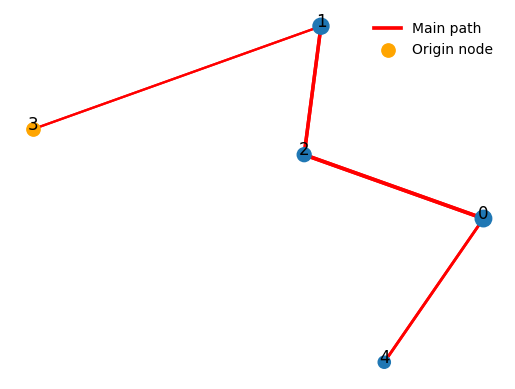


main path: ['3', '1', '2', '0', '4']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

mean: 7.965 
median: 4.125 
lower quantile: -2.780 
upper quantile: 14.293 
minimum: -73.064 
maximum: 155.546 
No. of positive scores: 239

'path_dict' added to adata.uns
'child_dict' added to adata.uns
'level_dict' added to adata.uns
'threshold_list' added to adata.uns
'd_nn' added to adata.obsp


Model training: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s, cos_s=0.891, cos_u=0.821, mse_s=0.007, mse_u=0.01]


computing velocity graph (using 20/20 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


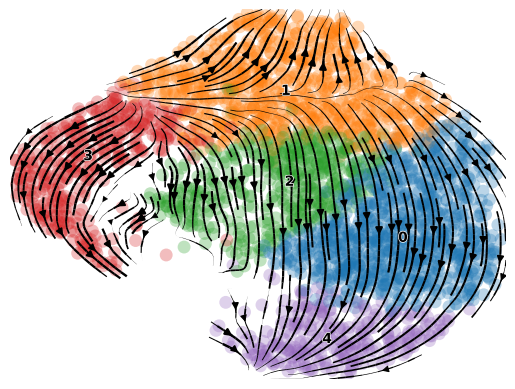

In [5]:
adata_ = tivelo(adata, group_key, emb_key, data_name=data_name, save_folder=save_folder, njobs=-1, tree_gene=tree_gene,
                show_fig=show_fig, filter_genes=filter_genes, constrain=constrain, loss_fun=loss_fun, only_s=only_s,
                alpha_1=alpha_1, alpha_2=alpha_2, batch_size=batch_size, n_epochs=n_epochs, velocity_key="velocity",
                adjust_DTI=adjust_DTI, show_DTI=show_DTI, cluster_edges=None,
                measure_performance=measure_performance)

In [6]:
def get_classification_scores(velo_sign_true, velo_sign_pred, score_fun):
    n_vars = velo_sign_true.shape[1]
    velo_score = [score_fun(velo_sign_true[:, var_id], velo_sign_pred[:, var_id]) for var_id in range(n_vars)]

    return velo_score

Calculate empirical velocity and estimated velocity, then calculate the sign accuracy.

In [7]:
# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_.obs["cell_cycle_position"].unique())):
    mask = (adata_.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_.obs["cell_cycle_position"].unique())):
    mask = (adata_.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of TIVelo: {:4f}".format(np.mean(velo_score)))


100%|██████████| 290/290 [00:00<00:00, 8128.22it/s]

Accuracy of TIVelo: 0.518167


## scVelo
Stochastic mode.

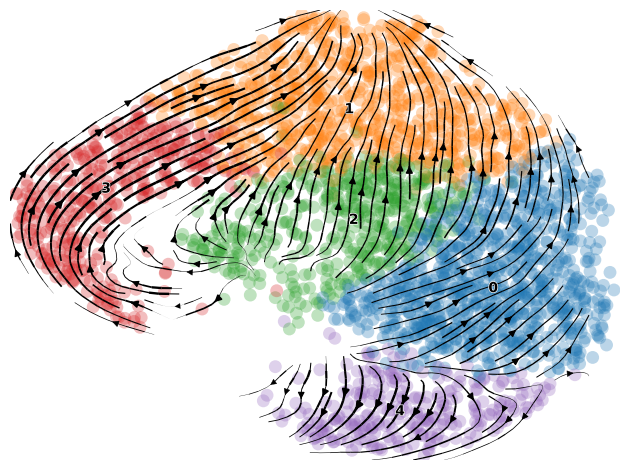

100%|██████████| 290/290 [00:00<00:00, 3272.39it/s]


Accuracy of scVelo: 0.467131


In [8]:
adata_scvelo = run_baseline(adata, "scvelo", data_name, group_key, emb_key, show_fig=True, 
                            measure_performance=measure_performance)

# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_scvelo.obs["cell_cycle_position"].unique())):
    mask = (adata_scvelo.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_scvelo.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_scvelo.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_scvelo.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_scvelo.obs["cell_cycle_position"].unique())):
    mask = (adata_scvelo.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_scvelo.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of scVelo: {:4f}".format(np.mean(velo_score)))

Dynamical mode.

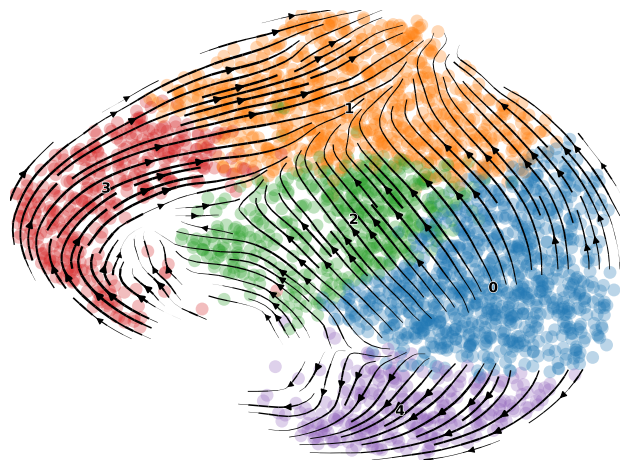

100%|██████████| 290/290 [00:02<00:00, 102.35it/s]

Accuracy of scVelo2: 0.488662


In [ ]:
adata_scvelo2 = run_baseline(adata, "scvelo2", data_name, group_key, emb_key, show_fig=True, 
                             measure_performance=measure_performance)

adata_scvelo2 = adata_scvelo2[:, adata_scvelo2.var.loc[adata_scvelo2.var['{}_genes'.format(velocity_key)] == True].index]

# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_scvelo2.obs["cell_cycle_position"].unique())):
    mask = (adata_scvelo2.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_scvelo2.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_scvelo2.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_scvelo2.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_scvelo2.obs["cell_cycle_position"].unique())):
    mask = (adata_scvelo2.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_scvelo2.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of scVelo2: {:4f}".format(np.mean(velo_score)))

## veloVI

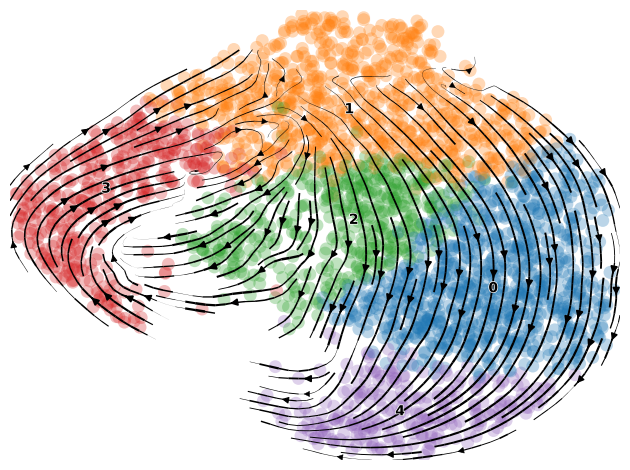

100%|██████████| 290/290 [00:00<00:00, 13981.33it/s]

(290, 77)
Accuracy of veloVI: 0.501702


In [10]:
adata_velovi = run_baseline(adata, "velovi", data_name, group_key, emb_key, show_fig=True, 
                            measure_performance=measure_performance)

# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_velovi.obs["cell_cycle_position"].unique())):
    mask = (adata_velovi.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_velovi.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_velovi.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_velovi.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_velovi.obs["cell_cycle_position"].unique())):
    mask = (adata_velovi.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_velovi.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)
print(aggr_velo_sign.shape)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of veloVI: {:4f}".format(np.mean(velo_score)))

## UniTVelo

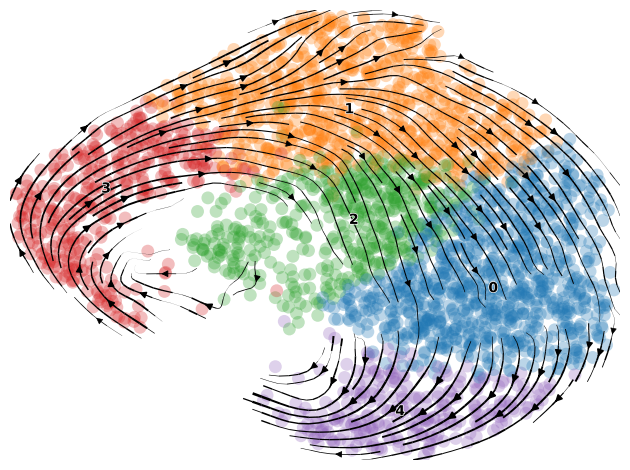

100%|██████████| 290/290 [00:00<00:00, 4214.26it/s]


Accuracy of UniTVelo: 0.501624


In [8]:
adata_unitvelo = run_baseline(adata, "unitvelo", data_name, group_key, emb_key, show_fig=True, 
                              measure_performance=measure_performance, unitvelo_mode="2")

# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_unitvelo.obs["cell_cycle_position"].unique())):
    mask = (adata_unitvelo.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_unitvelo.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_unitvelo.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_unitvelo.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_unitvelo.obs["cell_cycle_position"].unique())):
    mask = (adata_unitvelo.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_unitvelo.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of UniTVelo: {:4f}".format(np.mean(velo_score)))

## cellDancer

We don't directly run cellDancer here since the environment required by cellDancer may conflict that of TIVelo. We recommend running cellDancer in an independent environment.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_S_umap', embedded velocity vectors (adata.obsm)


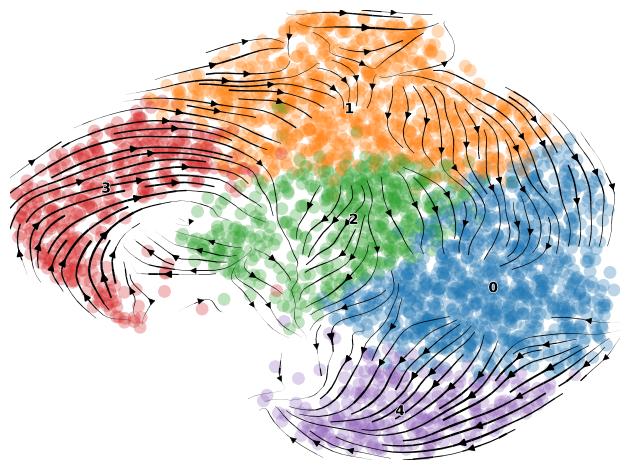

100%|██████████| 290/290 [00:00<00:00, 9261.63it/s]

Accuracy of cellDancer: 0.509163


In [12]:
velocity_key = "velocity_S"
adata_celldancer = run_baseline(adata, "celldancer", data_name, group_key, emb_key, show_fig=True, 
                              measure_performance=measure_performance)

# empirical velocity
aggr_counts = []
for pos in tqdm(np.sort(adata_celldancer.obs["cell_cycle_position"].unique())):
    mask = (adata_celldancer.obs["cell_cycle_position"] == pos).values
    aggr_counts.append(np.median(adata_celldancer.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_celldancer.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata_celldancer.obs["cell_cycle_rad"].values
cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(np.sort(adata_celldancer.obs["cell_cycle_position"].unique())):
    mask = (adata_celldancer.obs["cell_cycle_position"] == pos).values
    aggr_velo.append(np.median(adata_celldancer.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign, 
                                       score_fun=accuracy_score)
print("Accuracy of cellDancer: {:4f}".format(np.mean(velo_score)))

## DeepVelo

We don't directly run DeepVelo here since the environment required by DeepVelo may conflict that of TIVelo. We recommend running DeepVelo in an independent environment.

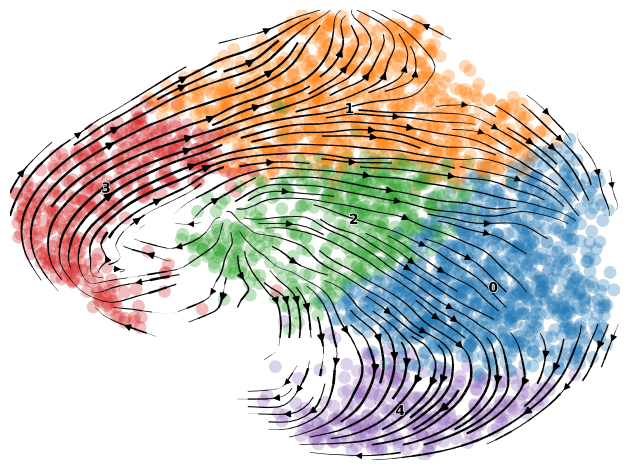

In [4]:
velocity_key = "velocity"
adata_deepvelo = sc.read("/users/s1155184322/projects/tutorial/DeepVelo/results/rpe1_deepvelo.h5ad")

ax = scv.pl.velocity_embedding_stream(adata_deepvelo, vkey=velocity_key, color=group_key, title="", show=False)
plt.tight_layout()

In [7]:
# empirical velocity
cell_cycle_pos = np.sort(adata_deepvelo.obs["cell_cycle_rad"].unique())[:-1]
aggr_counts = []
for pos in tqdm(cell_cycle_pos):
    if pos == 0:
        mask = ((adata_deepvelo.obs["cell_cycle_rad"] == 0) | (adata_deepvelo.obs["cell_cycle_rad"] == 2 * np.pi)).values
    else:
        mask = (adata_deepvelo.obs["cell_cycle_rad"] == pos).values
    aggr_counts.append(np.median(adata_deepvelo.layers["Ms"][mask, :], axis=0))
aggr_counts = np.vstack(aggr_counts)

reorder_mask = np.arange(1, adata_deepvelo.obs["cell_cycle_rad"].nunique() - 1).tolist() + [0]
cc_pos_diff = cell_cycle_pos.copy()
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)
empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)
empirical_velo_sign = np.sign(empirical_velo)

# estimated velocity
aggr_velo = []
for pos in tqdm(cell_cycle_pos):
    if pos == 0:
        mask = ((adata_deepvelo.obs["cell_cycle_rad"] == 0) | (adata_deepvelo.obs["cell_cycle_rad"] == 2 * np.pi)).values
    else:
        mask = (adata_deepvelo.obs["cell_cycle_rad"] == pos).values
    aggr_velo.append(np.median(adata_deepvelo.layers[velocity_key][mask, :], axis=0))
aggr_velo = np.vstack(aggr_velo)
aggr_velo_sign = np.sign(aggr_velo)

velo_score = get_classification_scores(velo_sign_true=empirical_velo_sign, velo_sign_pred=aggr_velo_sign,
                                           score_fun=accuracy_score)
print("Accuracy of DeepVelo: {:4f}".format(np.mean(velo_score)))

100%|██████████| 289/289 [00:00<00:00, 2161.92it/s]


Accuracy of DeepVelo: 0.500197
